<a href="https://colab.research.google.com/github/mrmattuschka/DeePiCt/blob/colab_notebook/DeePiCt_predict2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeePiCt 2D U-Net segmentation

Description for what is this Colab notebook, and how to use it ...

### 1. Installations
___

- Get the git repository

In [ ]:
!git clone https://github.com/mrmattuschka/DeePiCt.git

- Install required packages

In [ ]:
!pip install mrcfile
!pip install h5py==2.10.0
!pip install tensorflow-gpu==2.0.0
!pip install keras==2.3.1

3. Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 2. Set the data variables and config file

___

1. Create variables 

> Define the following information in the given variables:
*   **tomo_name** - ID/name for the tomogram
*   **user_config_file** - path where to save the config yaml file (created next)
*   **user_data_file** - path where to save the data csv file (created next)
*   **user_prediction_folder** - path to folder where to save prediction files
*   **user_work_folder** - path to folder where to save intermediate files


In [ ]:
srcdir = '/content/DeePiCt/2d_cnn'
original_config_file = '/content/drive/MyDrive/tomo_data/config_cyto.yaml'
model_path = '/content/drive/MyDrive/tomo_data/vpp_cytosol_model.h5'
target_spectrum_path = '/content/drive/MyDrive/tomo_data/spectrum.tsv'

# Define the folowing variables:
tomo_name = 'TS_045_rec'
user_config_file = '/content/config.yaml'
user_data_file = '/content/data.csv'
user_prediction_folder = '/content/drive/MyDrive/tomo_data/predictions/'

!mkdir {user_prediction_folder}

mkdir: cannot create directory ‘/content/drive/MyDrive/tomo_data/predictions/’: File exists


2. Create data csv file



> Define the following information in the `data` list for the tomogram of interest:
*   **tomo_name** - name for the tomogram
*   **id** - id used for the tomogram
*   **data** - path to the tomogram mrc/rec file




In [ ]:
import csv

header = ['tomo_name','id','data','filtered_data']

# Define the elements of this list:
data = ['TS_045_rec','TS_045_rec','/content/drive/MyDrive/tomo_data/TS_045_rec.mrc', '/content/drive/MyDrive/tomo_data/TS_045_filtered.mrc']

with open(user_data_file, 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write the data
    writer.writerow(data)
  
data_dictionary = dict(zip(header, data))

3. Create yaml config file

In [ ]:
import yaml

def read_yaml(file_path):
    with open(file_path, "r") as stream:
        data = yaml.safe_load(stream)
    return data

def save_yaml(data, file_path):
    with open(file_path, 'w') as yaml_file:
        yaml.dump(data, yaml_file, default_flow_style=False)

d = read_yaml(original_config_file)
d['prediction_data'] = user_data_file
d['output_dir'] = user_prediction_folder

d['preprocessing']['filtering']['active'] = True
d['preprocessing']['filtering']['target_spectrum'] = target_spectrum_path
d['preprocessing']['filtering']['lowpass_cutoff'] = 350
d['preprocessing']['filtering']['smoothen_cutoff'] = 20

d['training']['evaluation']['active'] = False
d['training']['production']['active'] = False

d['prediction']['active'] = True
d['prediction']['model'] = model_path

save_yaml(d, user_config_file)

## Step 3. Preprocess the tomogram

___

***NOTE:*** do the filtering with spectrum equalization on a local device, here it fails because of memory error:

In [ ]:
!python /content/DeePiCt/2d_cnn/scripts/match_spectrum.py --input {data_dictionary['data']} \
        --target {d['preprocessing']['filtering']['target_spectrum']} \
        --output {data_dictionary['filtered_data']} \
        --cutoff {d['preprocessing']['filtering']['lowpass_cutoff']} \
        --smoothen {d['preprocessing']['filtering']['smoothen_cutoff']}

tcmalloc: large alloc 1781760000 bytes == 0x561834a3c000 @  0x7f6c1694e1e7 0x7f6c1450e46e 0x7f6c1455ec7b 0x7f6c1455ed97 0x7f6c145f7887 0x5617fbfbd390 0x5617fc0afb3d 0x5617fc031458 0x5617fbfbe9da 0x5617fc02ceae 0x5617fc02c02f 0x5617fc02bd43 0x5617fc0f6302 0x5617fc0f667d 0x5617fc0f6526 0x5617fc0ce1d3 0x5617fc0cde7c 0x7f6c15738bf7 0x5617fc0cdd5a
23
27
tcmalloc: large alloc 7127040000 bytes == 0x56189edf0000 @  0x7f6c1694e1e7 0x7f6c1450e46e 0x7f6c1455ec7b 0x7f6c1455ed97 0x7f6c1455efe9 0x7f6c14561d7d 0x7f6c07a1b560 0x5617fbfbd317 0x5617fbfbd120 0x5617fc031679 0x5617fbfbe9da 0x5617fc02ceae 0x5617fc02c02f 0x5617fbefde2b 0x7f6c1454bef7 0x5617fbfbd317 0x5617fbfbd120 0x5617fc030f33 0x5617fc02c02f 0x5617fbfbeaba 0x5617fc02dcd4 0x5617fc02c02f 0x5617fbfbeaba 0x5617fc02ceae 0x5617fc02c02f 0x5617fbefdeb0 0x7f6c1454bef7 0x5617fbfbd317 0x5617fbfbd120 0x5617fc030f33 0x5617fc02c02f
tcmalloc: large alloc 7127040000 bytes == 0x561a482d2000 @  0x7f6c1694e1e7 0x7f6c1450e46e 0x7f6c1455ec7b 0x7f6c1455ed97 0x7f

## Step 4. Predict with trained neural network

___

In [ ]:
import os

prediction = os.path.join(user_prediction_folder, data_dictionary['id'] + "_pred.mrc")

In [ ]:
!python /content/DeePiCt/2d_cnn/scripts/predict_organelles.py \
        --features {data_dictionary['filtered_data']} \
        --output {prediction} \
        --model {model_path} \
        --config {user_config_file}

## Step 5. Post-processing of the prediction

___


In [ ]:
import os

post_processed_prediction = os.path.join(user_prediction_folder, data_dictionary['id'] + "_post_processed_pred.mrc")

In [ ]:
!python3 /content/DeePiCt/2d_cnn/scripts/postprocess.py \
        --input {prediction} \
        --output {post_processed_prediction} \
        --config {user_config_file}

# Step 6. Visualize results

___

In [ ]:
import mrcfile


def read_tomogram(filename):
    with mrcfile.open(filename, permissive=True) as m:
        return m.data

1. Read the tomogram and the prediction

In [ ]:
tomogram = read_tomogram(data_dictionary['filtered_data'])
predictions = read_tomogram(post_processed_prediction)

2. Visualize the prediction

> Define the z axis for visualization (variable `z_axis`)



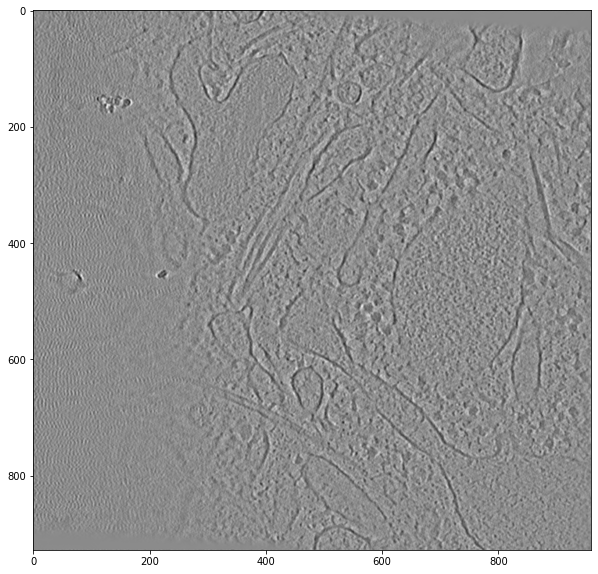

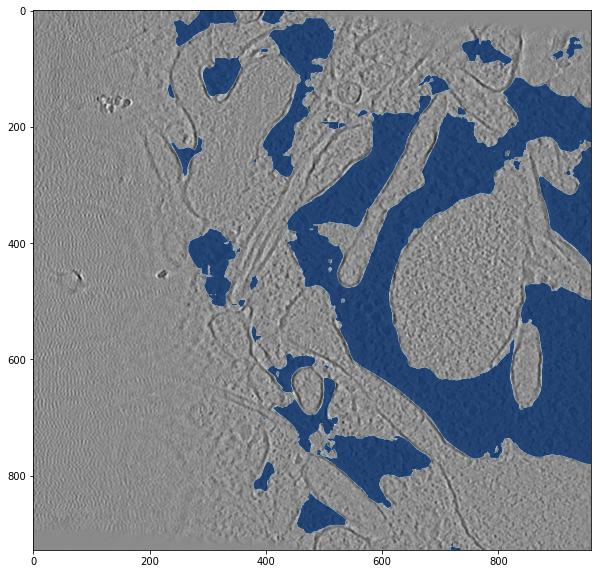

In [ ]:
z_axis = 200

import numpy as np
import matplotlib.pyplot as plt

# First figure
plt.figure(figsize = (10,10))
plt.imshow(tomogram[z_axis], cmap='gray')

# Second figure
plt.figure(figsize = (10,10))
plt.imshow(tomogram[z_axis], cmap='gray')
alphas = np.zeros(predictions.shape)
alphas[predictions > 0] = 0.8
plt.imshow(predictions[z_axis], alpha=alphas[z_axis], cmap='Blues')